# Law Chatbot Using Retrieval Augmented Generation (RAG)

This project aims to develop a Large Language Model (LLM) with Retrieval Augmented Generation (RAG) support.

Specifically, we'd like to be able to open a PDF file, ask questions (queries) of it and have them answered by a Large Language Model (LLM).

RAG stands for Retrieval Augmented Generation.

It was introduced in the paper [*Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks*](https://arxiv.org/abs/2005.11401).

Each step can be roughly broken down to:

* **Retrieval** - Seeking relevant information from a source given a query. For example, getting relevant passages of Wikipedia text from a database given a question.
* **Augmented** - Using the relevant retrieved information to modify an input to a generative model (e.g. an LLM).
* **Generation** - Generating an output given an input. For example, in the case of an LLM, generating a passage of text given an input prompt.

## Why RAG?

The primary goal of Retrieval-Augmented Generation (RAG) is to enhance the output quality of large language models (LLMs).

Two primary improvements can be seen as:
1. **Preventing hallucinations** - LLMs are powerful but can sometimes generate plausible yet incorrect information. RAG pipelines mitigate this by providing factual inputs, leading to more accurate outputs. Even if the answer from a RAG pipeline is questionable, the retrieval process provides access to the original sources, ensuring transparency.
2. **Work with custom data** - While base LLMs excel at general language tasks due to their broad training on internet-scale text, they often lack specific domain knowledge. RAG systems address this by supplying LLMs with specialized data, such as medical records or corporate documentation, tailoring their outputs to specific applications.

## Setting Up Our Workspace

**Fetching Necessary Libraries**

In [1]:
import os

if "COLAB_GPU" in os.environ:
    print(" Running in Google Colab, installing requirements.")
    !pip install -U torch # requires torch 2.1.1+ (for efficient sdpa implementation)
    !pip install PyMuPDF # for reading PDFs with Python
    !pip install tqdm # for progress bars
    !pip install sentence-transformers # for embedding models
    !pip install accelerate # for quantization model loading
    !pip install bitsandbytes # for quantizing models (less storage space)
    !pip install flash-attn --no-build-isolation # for faster attention mechanism = faster LLM inference

 Running in Google Colab, installing requirements.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 53.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for flash-attn: filename=flash_attn-2.7.3-cp311-cp311-linux_x86_64.whl size=191363917 sha256=b1243e9b86687348a5ab03a073abacdf8e3d5e9e4b7e5326a183f47348c5dfba
  Stored in directory: /root/.cache/pip/wheels/d0/a3/f9/48d2706cb2eac05ec0dc144bf6954fe47bb3c2cd0de280765e
Successfully built flash-attn


## Building Our Pipeline

###  1. Text Processing

Steps:

1. Import the PDF document(s).
2. Prepare the text for embedding by segmenting it into chunks of sentences.

**Importing PDF Documents**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We can import the pages of our PDF(s) as text by first defining the PDF paths and then opening and reading it with PyMuPDF (`import fitz`).

In [3]:
import os

# Get PDF document
dir_path = "/content/drive/MyDrive/Colab Notebooks/LawBot Docs/"

filenames = [] # Loop through the files in the specified directory
for filename in os.listdir(dir_path):
  # Check if it is a file (excluding directories)
  if os.path.isfile(os.path.join(dir_path, filename)):
    filenames.append(os.path.join(dir_path, filename))

In [4]:
filenames[:1]

['/content/drive/MyDrive/Colab Notebooks/LawBot Docs/CONSTITUTION OF INDIA.pdf']

We'll write a small helper function to preprocess the text as it gets read and save each page to a dictionary and then append that dictionary to a list for ease of use later.

> **Resource:** [PyMuPDF](https://github.com/pymupdf/pymupdf)

In [5]:
import fitz # (package name for pymupdf)
from tqdm.auto import tqdm # for progress bars

def text_formatter(text: str) -> str:
    """Performs minor formatting on text."""
    cleaned_text = text.replace("  +", " ") # removing empty spaces
    cleaned_text = text.replace("_+", "") # removing underlines
    cleaned_text = text.replace("\n", " ").strip() # replacing new lines with spaces
    return cleaned_text

# Open PDF and get lines/pages
def open_and_read_pdf(pdf_path: str) -> list[dict]:
    """
    Opens a PDF file, reads its text content page by page, and collects statistics.

    Parameters:
        pdf_path (str): The file path to the PDF document to be opened and read.

    Returns:
        list[dict]: A list of dictionaries, each containing the document name, page number,
        character count, word count, sentence count, token count, and the extracted text
        for each page.
    """
    doc = fitz.open(pdf_path)  # open a document
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):  # iterate the document pages
        text = page.get_text()  # get plain text encoded as UTF-8
        text = text_formatter(text)
        pages_and_texts.append({"doc_name": os.path.basename(pdf_path),
                                "page_number": page_number + 1,
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text) / 4,  # 1 token = ~4 chars,
                                "text": text})
    return pages_and_texts

pages_and_texts = []
for filename in filenames:
    pages_and_texts.extend(open_and_read_pdf(pdf_path=filename))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

**Checking out first two pages of the first PDF**

In [6]:
pages_and_texts[:2]

[{'doc_name': 'CONSTITUTION OF INDIA.pdf',
  'page_number': 1,
  'page_char_count': 187,
  'page_word_count': 32,
  'page_sentence_count_raw': 1,
  'page_token_count': 46.75,
  'text': '£ÉÉ®iÉ BÉEÉ ºÉÆÉÊ´ÉvÉÉxÉ  [1 , 2024 ] THE CONSTITUTION OF INDIA [As on 1st May, 2024]  2024 GOVERNMENT OF INDIA MINISTRY OF LAW AND JUSTICE LEGISLATIVE DEPARTMENT, OFFICIAL LANGUAGES WING'},
 {'doc_name': 'CONSTITUTION OF INDIA.pdf',
  'page_number': 2,
  'page_char_count': 891,
  'page_word_count': 151,
  'page_sentence_count_raw': 7,
  'page_token_count': 222.75,
  'text': 'PREFACE This is the  sixth pocket size edition of the Constitution of  India in the diglot form. In this edition, the text of the  Constitution of India has been brought up-to-date by  incorporating therein all the amendments up to the Constitution  (One Hundred and Sixth Amendment) Act, 2023. The foot notes  below the text indicate the Constitution Amendment Acts by  which such amendments have been made.  The Constitution (One Hun

**Getting some statistics**

Let's perform a rough exploratory data analysis (EDA) to get an idea of the size of the texts (e.g. character counts, word counts etc) we're working with.

The different sizes of texts will be a good indicator into how we should split our texts.

In [7]:
import pandas as pd
import random

df = pd.DataFrame(pages_and_texts)
df.sample(n=10)

,doc_name,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
1582,Company Law.pdf,643,2466,409,9,616.50,Lesson 15 n Board Constitution and its Powers ...
1848,Company Law.pdf,909,3302,626,18,825.50,Lesson 22 n Secretarial Standards Board 909 ...
1672,Company Law.pdf,733,3471,586,35,867.75,Lesson 17 n Appointment and Remuneration of Ke...
282,CONSTITUTION OF INDIA.pdf,283,2105,351,20,526.25,"252 PART XXII SHORT TITLE, COMMENCEMENT, 1[AUT..."
1256,Company Law.pdf,317,2636,467,13,659.00,"Lesson 8 n Accounts, Audit and Auditors 317 a..."
392,CONSTITUTION OF INDIA.pdf,393,1286,215,29,321.50,THE CONSTITUTION OF INDIA (Appendix I) 362 1...
1753,Company Law.pdf,814,3291,578,11,822.75,814 EP-CL Prior consent to act as a scrutin...
1575,Company Law.pdf,636,2077,330,6,519.25,636 EP-CL REGULATORY FRAMEWORK\t Companies ...
1291,Company Law.pdf,352,3703,602,18,925.75,352 EP-CL \t (b)\t indicating category wise...
328,CONSTITUTION OF INDIA.pdf,329,2352,440,3,588.00,THE CONSTITUTION OF INDIA (Sixth Schedule) 2...


In [8]:
# Get stats
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1887.00,1887.00,1887.00,1887.00,1887.00
mean,332.29,2826.69,494.26,16.81,706.67
std,256.78,895.10,153.40,9.79,223.78
min,1.00,11.00,5.00,1.00,2.75
25%,123.00,2312.50,412.00,10.00,578.12
50%,280.00,2947.00,515.00,15.00,736.75
75%,475.50,3462.50,601.50,23.00,865.62
max,947.00,4802.00,864.00,93.00,1200.50


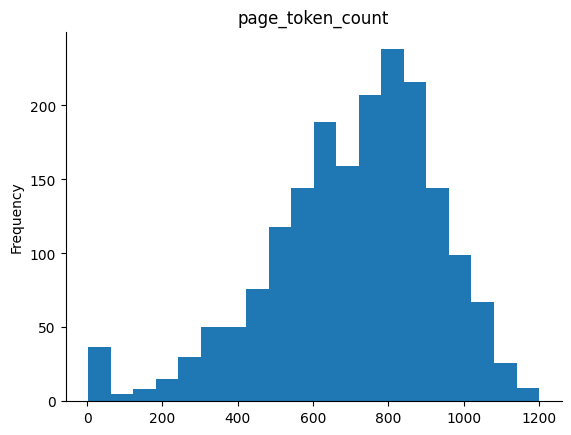

In [9]:
from matplotlib import pyplot as plt
df['page_token_count'].plot(kind='hist', bins=20, title='page_token_count')
plt.gca().spines[['top', 'right',]].set_visible(False)

**Further text processing**

We want to split pages into sentences and chunk them for easier embedding.

Some options for splitting text into sentences:

1. Split into sentences with simple rules (e.g. split on ". " with `text = text.split(". ")`, like we did above).
2. Split into sentences with a natural language processing (NLP) library such as [spaCy](https://spacy.io/) or [nltk](https://www.nltk.org/).

Why split into sentences?

* Easier to handle than larger pages of text (especially if pages are densely filled with text).
* Can get specific and find out which group of sentences were used to help within a RAG pipeline.

Let's use spaCy to break our text into sentences since it's likely a bit more robust than just using `text.split(". ")`.

> **Resource:** [spaCy install instructions](https://spacy.io/usage).

In [10]:
from spacy.lang.en import English

nlp = English()

# Add a sentencizer pipeline, see https://spacy.io/api/sentencizer/
nlp.add_pipe("sentencizer")

for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)

    # Make sure all sentences are strings
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]

    # Count the sentences
    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/1887 [00:00<?, ?it/s]

In [11]:
pages_and_texts[:4]

[{'doc_name': 'CONSTITUTION OF INDIA.pdf',
  'page_number': 1,
  'page_char_count': 187,
  'page_word_count': 32,
  'page_sentence_count_raw': 1,
  'page_token_count': 46.75,
  'text': '£ÉÉ®iÉ BÉEÉ ºÉÆÉÊ´ÉvÉÉxÉ  [1 , 2024 ] THE CONSTITUTION OF INDIA [As on 1st May, 2024]  2024 GOVERNMENT OF INDIA MINISTRY OF LAW AND JUSTICE LEGISLATIVE DEPARTMENT, OFFICIAL LANGUAGES WING',
  'sentences': ['£ÉÉ®iÉ BÉEÉ ºÉÆÉÊ´ÉvÉÉxÉ  [1 , 2024 ] THE CONSTITUTION OF INDIA [As on 1st May, 2024]  2024 GOVERNMENT OF INDIA MINISTRY OF LAW AND JUSTICE LEGISLATIVE DEPARTMENT, OFFICIAL LANGUAGES WING'],
  'page_sentence_count_spacy': 1},
 {'doc_name': 'CONSTITUTION OF INDIA.pdf',
  'page_number': 2,
  'page_char_count': 891,
  'page_word_count': 151,
  'page_sentence_count_raw': 7,
  'page_token_count': 222.75,
  'text': 'PREFACE This is the  sixth pocket size edition of the Constitution of  India in the diglot form. In this edition, the text of the  Constitution of India has been brought up-to-date by  incorpor

Let's review the new statistics.

In [12]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,1887.00,1887.00,1887.00,1887.00,1887.00,1887.00
mean,332.29,2826.69,494.26,16.81,706.67,16.60
std,256.78,895.10,153.40,9.79,223.78,9.19
min,1.00,11.00,5.00,1.00,2.75,1.00
25%,123.00,2312.50,412.00,10.00,578.12,10.00
50%,280.00,2947.00,515.00,15.00,736.75,16.00
75%,475.50,3462.50,601.50,23.00,865.62,22.00
max,947.00,4802.00,864.00,93.00,1200.50,76.00


For our set of text, it looks like our raw sentence count (e.g. splitting on `". "`) is quite close to what spaCy came up with.

Why do we do this?

1. Easier to manage similar sized chunks of text.
2. Don't overload the embedding models capacity for tokens (e.g. if an embedding model has a capacity of 384 tokens, there could be information loss if you try to embed a sequence of 400+ tokens).
3. Our LLM context window (the amount of tokens an LLM can take in) may be limited and requires compute power so we want to make sure we're using it as well as possible.

On average each of our pages has ~16 sentences and an average total of ~751 tokens per page.

So if we take groups of 8 sentences, then it will be ~375 tokens long.

This gives us plenty of room for the text to embedded by our `all-mpnet-base-v2` model (it has a capacity of 384 tokens).

In [13]:
# Define split size to turn groups of sentences into chunks
num_sentence_chunk_size = 8

# Create a function that recursively splits a list into desired sizes
def split_list(input_list: list,
               slice_size: int) -> list[list[str]]:
    """
    Splits the input_list into sublists of size slice_size (or as close as possible).

    """
    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]

# Loop through pages and texts and split sentences into chunks
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                         slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/1887 [00:00<?, ?it/s]

In [14]:
pages_and_texts[:1]

[{'doc_name': 'CONSTITUTION OF INDIA.pdf',
  'page_number': 1,
  'page_char_count': 187,
  'page_word_count': 32,
  'page_sentence_count_raw': 1,
  'page_token_count': 46.75,
  'text': '£ÉÉ®iÉ BÉEÉ ºÉÆÉÊ´ÉvÉÉxÉ  [1 , 2024 ] THE CONSTITUTION OF INDIA [As on 1st May, 2024]  2024 GOVERNMENT OF INDIA MINISTRY OF LAW AND JUSTICE LEGISLATIVE DEPARTMENT, OFFICIAL LANGUAGES WING',
  'sentences': ['£ÉÉ®iÉ BÉEÉ ºÉÆÉÊ´ÉvÉÉxÉ  [1 , 2024 ] THE CONSTITUTION OF INDIA [As on 1st May, 2024]  2024 GOVERNMENT OF INDIA MINISTRY OF LAW AND JUSTICE LEGISLATIVE DEPARTMENT, OFFICIAL LANGUAGES WING'],
  'page_sentence_count_spacy': 1,
  'sentence_chunks': [['£ÉÉ®iÉ BÉEÉ ºÉÆÉÊ´ÉvÉÉxÉ  [1 , 2024 ] THE CONSTITUTION OF INDIA [As on 1st May, 2024]  2024 GOVERNMENT OF INDIA MINISTRY OF LAW AND JUSTICE LEGISLATIVE DEPARTMENT, OFFICIAL LANGUAGES WING']],
  'num_chunks': 1}]

In [15]:
# Create a DataFrame to get stats
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,1887.00,1887.00,1887.00,1887.00,1887.00,1887.00,1887.00
mean,332.29,2826.69,494.26,16.81,706.67,16.60,2.52
std,256.78,895.10,153.40,9.79,223.78,9.19,1.17
min,1.00,11.00,5.00,1.00,2.75,1.00,1.00
25%,123.00,2312.50,412.00,10.00,578.12,10.00,2.00
50%,280.00,2947.00,515.00,15.00,736.75,16.00,2.00
75%,475.50,3462.50,601.50,23.00,865.62,22.00,3.00
max,947.00,4802.00,864.00,93.00,1200.50,76.00,10.00


**Creating a new dictionary of individul chunk items**

We aim to embed each chunk of sentences into its unique numerical representation.

To maintain clarity, we will create a list of dictionaries. Each dictionary will contain a single chunk of sentences along with relevant details such as the document name, page number and various statistics about the chunk.

In [16]:
import re

# Split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["doc_name"] = item["doc_name"]
        chunk_dict["page_number"] = item["page_number"]

        # Join the sentences together into a paragraph-like structure, aka a chunk (so they are a single string)
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" -> ". A" for any full-stop/capital letter combo
        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Get stats about the chunk
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = ~4 characters

        pages_and_chunks.append(chunk_dict)

# Total no. of chunks
len(pages_and_chunks)

  0%|          | 0/1887 [00:00<?, ?it/s]

4754

In [17]:
# View a random sample
random.sample(pages_and_chunks, k=1)

[{'doc_name': 'INTELLECTUAL PROPERTY RIGHTS-LAWS & PRACTICES.pdf',
  'page_number': 164,
  'sentence_chunk': 'If the patent agent above had forgotten to ask about possible bar dates or had not pressed the engineer for precise information, the patent agent might have returned to his office and spent the next two weeks drafting a beautiful legal document for an invention that could no longer be patented. Finally, the patent agent must try to understand early if the applicant wants to file in foreign countries. In countries that are Member States of the Paris Convention, applicants have one year to file their patent application abroad',
  'chunk_char_count': 529,
  'chunk_word_count': 89,
  'chunk_token_count': 132.25}]

In [18]:
# Get stats about our chunks
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,4754.00,4754.00,4754.00,4754.00
mean,315.18,1107.88,182.78,276.97
std,256.95,754.41,126.86,188.60
min,1.00,3.00,1.00,0.75
25%,106.00,466.00,76.00,116.50
50%,263.50,1053.00,172.00,263.25
75%,427.00,1550.75,257.75,387.69
max,947.00,4246.00,732.00,1061.50


It seems that some of our chunks have a relatively low token count.

Let's review the samples with fewer than 70 tokens (approximately the length of a sentence) to determine if they are worth retaining.

In [19]:
# Show random chunks with under 70 tokens in length
min_token_length = 70
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 43.5 | Text: by the Constitution (Forty-fourth Amendment) Act, 1978, s. 42 (w.e.f.20-6-1979).2. Art.361B ins.by the Constitution (Ninety-first Amendment) Act, 2003, s. 4 (w.e.f.1-1-2004).
Chunk token count: 39.75 | Text: The words and letter "of a State specified in Part A of the First Schedule" omitted by  s. 29 and Sch.,ibid. (w.e.f.1-11-1956).4. Subs.by s. 29 and Sch.,ibid.,
Chunk token count: 69.75 | Text: –	 The Copyright Act applies only to works first published in India, irrespective of the nationality of the author. However the Act empowers the Government of India to extend the benefits of all or any of the provisions of the Act to works first published in any foreign country.
Chunk token count: 53.25 | Text: 20. Protection in respect of conviction for offences.21. Protection of life and personal liberty.21A. Right to education.22. Protection against arrest and detention in certain cases. Right against Exploitation 23.
Chunk token count: 42.0 | Text: 1. Ins.b

These don't seem to offer too much information.

Let's filter our DataFrame/list of dictionaries to only include chunks with over 70 tokens in length.

In [20]:
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'doc_name': 'CONSTITUTION OF INDIA.pdf',
  'page_number': 2,
  'sentence_chunk': 'PREFACE This is the sixth pocket size edition of the Constitution of India in the diglot form. In this edition, the text of the Constitution of India has been brought up-to-date by incorporating therein all the amendments up to the Constitution (One Hundred and Sixth Amendment) Act, 2023. The foot notes below the text indicate the Constitution Amendment Acts by which such amendments have been made. The Constitution (One Hundredth Amendment) Act, 2015 containing details of acquired and transferred territories between the Governments of India and Bangladesh has been provided in Appendix I. The Constitution (Application to Jammu and Kashmir) Order, 2019 and the declaration under article 370(3) of the Constitution have been provided respectively in Appendix II and Appendix III for reference. New Delhi; Dr. Rajiv Mani, 1st May, 2024 Secretary to the Government of India.',
  'chunk_char_count': 877,
  'chunk_

### 2. Embedding Creation

Embeddings are numerical representations of data that capture the underlying relationships and patterns within the data. They convert complex, high-dimensional data into lower-dimensional vectors that can be easily processed by machine learning models.

Steps:
1. Use an embedding model to embed the text chunks.
2. Save the embeddings to a file for future reference, ensuring they are preserved.

Our goal is to turn each of our chunks into a numerical representation (an embedding vector, where a vector is a sequence of numbers arranged in order). To do so, we'll use the sentence-transformers library which contains many pre-trained embedding models. Specifically, we'll get the `all-mpnet-base-v2` model.

> **Resource:** [Hugging Face model card](https://huggingface.co/sentence-transformers/all-mpnet-base-v2#intended-uses).

In [21]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device="cuda")

# Create embeddings one by one on the GPU
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

  0%|          | 0/3997 [00:00<?, ?it/s]

In [22]:
pages_and_chunks_over_min_token_len[:1]

[{'doc_name': 'CONSTITUTION OF INDIA.pdf',
  'page_number': 2,
  'sentence_chunk': 'PREFACE This is the sixth pocket size edition of the Constitution of India in the diglot form. In this edition, the text of the Constitution of India has been brought up-to-date by incorporating therein all the amendments up to the Constitution (One Hundred and Sixth Amendment) Act, 2023. The foot notes below the text indicate the Constitution Amendment Acts by which such amendments have been made. The Constitution (One Hundredth Amendment) Act, 2015 containing details of acquired and transferred territories between the Governments of India and Bangladesh has been provided in Appendix I. The Constitution (Application to Jammu and Kashmir) Order, 2019 and the declaration under article 370(3) of the Constitution have been provided respectively in Appendix II and Appendix III for reference. New Delhi; Dr. Rajiv Mani, 1st May, 2024 Secretary to the Government of India.',
  'chunk_char_count': 877,
  'chunk_

To improve the speed of embedding creation we can perform batched operations by turning our target text samples into a single list and then passing that list to our embedding model.

In [23]:
# Turn text chunks into a single list
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]

# Embed all texts in batches
text_chunk_embeddings = embedding_model.encode(text_chunks,
                                               batch_size=32,
                                               convert_to_tensor=True) # optional to return embeddings as tensor instead of array

text_chunk_embeddings

tensor([[ 0.0224, -0.0303, -0.0181,  ..., -0.0046, -0.0510,  0.0140],
        [ 0.0093, -0.0160, -0.0035,  ..., -0.0017, -0.0399,  0.0033],
        [-0.0115, -0.0169, -0.0116,  ..., -0.0064, -0.0834, -0.0670],
        ...,
        [ 0.0532, -0.0479, -0.0101,  ...,  0.0604, -0.0824, -0.0200],
        [-0.0011, -0.0608,  0.0060,  ...,  0.0361, -0.0699, -0.0092],
        [ 0.0290, -0.0261, -0.0015,  ...,  0.0074,  0.0087, -0.0358]],
       device='cuda:0')

**Saving embeddings to a file**

1.   List item
2.   List item



In [24]:
# Save embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "/content/drive/MyDrive/Colab Notebooks/text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [25]:
# Import saved file and view
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

,doc_name,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,CONSTITUTION OF INDIA.pdf,2,PREFACE This is the sixth pocket size edition ...,877,137,219.25,[ 2.24177763e-02 -3.03115100e-02 -1.80844814e-...
1,CONSTITUTION OF INDIA.pdf,3,.................................................,285,25,71.25,[ 9.27644689e-03 -1.60425883e-02 -3.50105157e-...
2,CONSTITUTION OF INDIA.pdf,3,.................................................,305,20,76.25,[-1.15008047e-02 -1.68859232e-02 -1.16083147e-...
3,CONSTITUTION OF INDIA.pdf,4,THE CONSTITUTION OF INDIA ____________ ...,423,135,105.75,[ 9.68075916e-03 9.39207245e-03 1.19606755e-...
4,CONSTITUTION OF INDIA.pdf,4,Laws made under articles 2 and 3 to provide fo...,375,57,93.75,[ 1.95069890e-02 -1.90714803e-02 -8.92498356e-...


### 3. RAG - Search and Answer

Let's import our embeddings we created earlier (tk -link to embedding file) and prepare them for use by turning them into a tensor.

In [26]:
import random

import torch
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

# Import texts and embedding df
text_chunks_and_embedding_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/text_chunks_and_embeddings_df.csv")

# Convert embedding column back to np.array (it got converted to string when it got saved to CSV)
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

# Convert embeddings to torch tensor and send to device (NumPy arrays are float64, torch tensors are float32 by default)
embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)
embeddings.shape

torch.Size([3997, 768])

In [27]:
text_chunks_and_embedding_df.head()

,doc_name,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,CONSTITUTION OF INDIA.pdf,2,PREFACE This is the sixth pocket size edition ...,877,137,219.25,"[0.0224177763, -0.03031151, -0.0180844814, -0...."
1,CONSTITUTION OF INDIA.pdf,3,.................................................,285,25,71.25,"[0.00927644689, -0.0160425883, -0.00350105157,..."
2,CONSTITUTION OF INDIA.pdf,3,.................................................,305,20,76.25,"[-0.0115008047, -0.0168859232, -0.0116083147, ..."
3,CONSTITUTION OF INDIA.pdf,4,THE CONSTITUTION OF INDIA ____________ ...,423,135,105.75,"[0.00968075916, 0.00939207245, 0.00119606755, ..."
4,CONSTITUTION OF INDIA.pdf,4,Laws made under articles 2 and 3 to provide fo...,375,57,93.75,"[0.019506989, -0.0190714803, -0.000892498356, ..."


In [28]:
embeddings[0]

tensor([ 2.2418e-02, -3.0312e-02, -1.8084e-02, -2.5348e-02, -6.8393e-02,
         7.4178e-03, -1.3282e-02, -2.9587e-03,  1.2193e-02,  1.3353e-02,
         4.7622e-02,  9.0665e-03,  2.9397e-02,  1.9338e-02,  2.0878e-02,
        -4.0783e-02, -1.2623e-02, -1.1728e-02, -4.3279e-02,  3.4063e-02,
        -4.3910e-02, -1.7166e-03, -1.8662e-02,  1.8241e-02,  5.1702e-03,
         1.0766e-02,  2.5671e-02,  8.3798e-03, -7.9389e-02, -3.4386e-02,
         2.2991e-02,  1.9258e-03,  7.1120e-02, -8.3680e-02,  2.3294e-06,
        -4.9332e-02,  9.3029e-03,  4.2666e-02, -2.0306e-02,  3.2260e-02,
         2.5439e-03,  1.2478e-02,  2.7508e-03,  1.3983e-02, -1.9507e-02,
         3.0786e-02, -1.5114e-02,  9.5301e-02,  3.5190e-02,  8.8924e-02,
         2.5292e-02, -2.0379e-02, -4.6152e-02, -1.7119e-02,  1.6524e-02,
        -4.3402e-03, -1.2352e-02, -1.7754e-02,  3.3328e-02,  3.1630e-02,
        -7.1860e-03, -5.5680e-03,  8.5886e-03, -4.9701e-02,  4.6993e-03,
        -3.4258e-02,  2.1059e-02, -1.1914e-02,  1.0

**Similarity/Semantic Search**

Semantic search is an advanced search technique that aims to improve search accuracy by understanding the context and meaning behind the search query. Instead of relying solely on keyword matching, semantic search algorithms consider the intent, context, and relationships between words to deliver more relevant and accurate search results.

We want to perform semantic search between our available data (documents) and any query.

Well, we can do so with the following steps:
1. Define a query string (e.g. `"IT Act characteristics"`) - note: this could be anything, specific or not.
2. Turn the query string in an embedding with same model we used to embed our text chunks.
3. Perform a [dot product](https://pytorch.org/docs/stable/generated/torch.dot.html) or [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) function between the text embeddings and the query embedding to get similarity scores.
4. Sort the results from step 3 in descending order (a higher score means more similarity in the eyes of the model) and use these values to inspect the texts.

In [29]:
from sentence_transformers import util

# 1. Define the query
query = "Intellectual Property rights"
print(f"Query: {query}")

# 2. Embed the query to the same numerical space as the text examples
query_embedding = embedding_model.encode(query, convert_to_tensor=True)

# 3. Get similarity scores with the dot product
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

# 4. Get the top-k results (we'll keep this to 5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: Intellectual Property rights
Time take to get scores on 3997 embeddings: 0.03075 seconds.


torch.return_types.topk(
values=tensor([0.7591, 0.7530, 0.7504, 0.7404, 0.7300], device='cuda:0'),
indices=tensor([ 959,  956, 1047, 1984, 1002], device='cuda:0'))

In [30]:
# Define helper function to print wrapped text
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [31]:
print(f"Query: '{query}'\n")
print("Results:")
# Loop through zipped together scores and indicies from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    # Print the page number too so we can reference the textbook further (and check the results)
    print(f"PDF name: {pages_and_chunks[idx]['doc_name']}")
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'Intellectual Property rights'

Results:
Score: 0.7591
Text:
Lesson 1 n Introduction 3 have been brought under the umbrella of Intellectual
Property. Intellectual Property Rights are like any other property rights. They
allow the creators (or owners) of Patents, Trademarks or Copyrighted works (as
the case may be) to benefit from their own respective work or investment in a
creation. These rights are outlined in Article 27 of the Universal Declaration
of Human Rights, which provides for the right to benefit from the protection of
moral and material interests resulting from authorship of scientific, literary
or artistic productions. The importance of Intellectual Property was first
recognized in the Paris Convention for the Protection of Industrial Property
(1883) and the Berne Convention for the Protection of Literary and Artistic
Works (1886). Both treaties are administered by the World Intellectual Property
Organization (WIPO). In short, Property Rights in ideas are no differe

The third result seems to be the most relevant, let's inspect the page from the pdf.

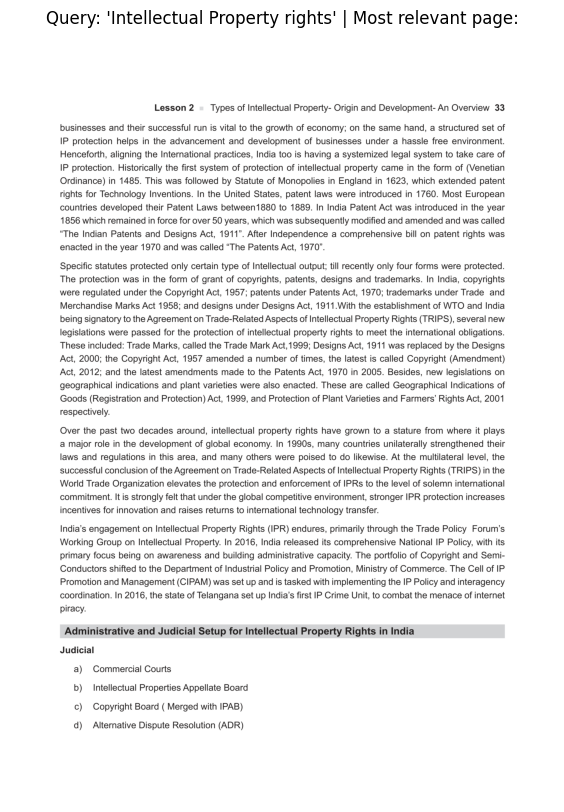

In [32]:
import fitz

# Open PDF and load target page
pdf_path = os.path.join("/content/drive/MyDrive/Colab Notebooks/LawBot Docs/", pages_and_chunks[top_results_dot_product[1][2]]['doc_name'])
doc = fitz.open(pdf_path)
page = doc.load_page(pages_and_chunks[top_results_dot_product[1][2]]['page_number']) # number of page

# Get the image of the page
img = page.get_pixmap(dpi=300)
doc.close()

# Convert the Pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv,
                          dtype=np.uint8).reshape((img.h, img.w, img.n))

# Display the image using Matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis('off') # Turn off axis
plt.show()

**Functionizing our semantic search pipeline**

In [33]:
from sentence_transformers import util, SentenceTransformer

def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """

    # Embed the query
    query_embedding = model.encode(query,
                                   convert_to_tensor=True)

    # Get dot product scores on embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_scores,
                                 k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    """
    Takes a query, retrieves most relevant resources and prints them out in descending order.

    Note: Requires pages_and_chunks to be formatted in a specific way (see above for reference).
    """

    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)

    print(f"Query: {query}\n")
    print("Results:")
    # Loop through zipped together scores and indicies
    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")
        # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])
        # Print the page number too so we can reference the textbook further and check the results
        print(f"PDF name: {pages_and_chunks[idx]['doc_name']}")
        print(f"Page number: {pages_and_chunks[index]['page_number']}")
        print("\n")

Let's test out our semantic search pipeline

In [34]:
query = "Intellectual Property rights"

# Print out the texts of the top scores
print_top_results_and_scores(query=query,
                             embeddings=embeddings)

[INFO] Time taken to get scores on 3997 embeddings: 0.00010 seconds.
Query: Intellectual Property rights

Results:
Score: 0.7591
Lesson 1 n Introduction 3 have been brought under the umbrella of Intellectual
Property. Intellectual Property Rights are like any other property rights. They
allow the creators (or owners) of Patents, Trademarks or Copyrighted works (as
the case may be) to benefit from their own respective work or investment in a
creation. These rights are outlined in Article 27 of the Universal Declaration
of Human Rights, which provides for the right to benefit from the protection of
moral and material interests resulting from authorship of scientific, literary
or artistic productions. The importance of Intellectual Property was first
recognized in the Paris Convention for the Protection of Industrial Property
(1883) and the Berne Convention for the Protection of Literary and Artistic
Works (1886). Both treaties are administered by the World Intellectual Property
Organizat

### 4. Using LLM for generation

To perform generation, we're going to use a Large Language Model (LLM). LLMs are designed to generate an output given an input.

In our case, we want our LLM to generate and output text given an input text. More specifically, we want the output of text to be generated based on the context of relevant information to the query.

**Checking available GPU memory**

In [35]:
# Get GPU available memory
import torch
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f"Available GPU memory: {gpu_memory_gb} GB")

Available GPU memory: 15 GB


Let's try out the recently released LLM from Google, [Gemma](https://huggingface.co/blog/gemma).

Specifically, we'll use the `gemma-2b-it` version which stands for Gemma 2B Instruction-Tuned.

The following table shows different amounts of GPU memory requirements for different verions of the Gemma LLMs with varying levels of precision.

| Model             | Precision | Min-Memory (Bytes) | Min-Memory (MB) | Min-Memory (GB) | Recommended Memory (GB) | Hugging Face ID |
|-------------------|-----------|----------------|-------------|-------------| ----- | ----- |
| [Gemma 2B](https://huggingface.co/google/gemma-2b-it)          | 4-bit     | 2,106,749,952  | 2009.15     | 1.96        | ~5.0 | [`gemma-2b`](https://huggingface.co/google/gemma-2b) or [`gemma-2b-it`](https://huggingface.co/google/gemma-2b-it) for instruction tuned version |
| Gemma 2B          | Float16   | 5,079,453,696  | 4844.14     | 4.73        | ~8.0 | Same as above |
| [Gemma 7B](https://huggingface.co/google/gemma-7b-it)          | 4-bit     | 5,515,859,968  | 5260.33     | 5.14        | ~8.0 | [`gemma-7b`](https://huggingface.co/google/gemma-7b) or [`gemma-7b-it`](https://huggingface.co/google/gemma-7b-it) for instruction tuned version |
| Gemma 7B          | Float16   | 17,142,470,656 | 16348.33    | 15.97       | ~19 | Same as above |

To load our LLM, we're going to need a few things:
1. A quantization config (optional) - This will determine whether or not we load the model in 4bit precision for lower memory usage. The we can create this with the [`transformers.BitsAndBytesConfig`](https://huggingface.co/docs/transformers/v4.38.2/en/main_classes/quantization#transformers.BitsAndBytesConfig) class (requires installing the [`bitsandbytes` library](https://github.com/TimDettmers/bitsandbytes)).
2. A model ID - This is the reference Hugging Face model ID which will determine which tokenizer and model gets used. For example `gemma-2b-it`.
3. A tokenzier - This is what will turn our raw text into tokens ready for the model. We can create it using the [`transformers.AutoTokenzier.from_pretrained`](https://huggingface.co/docs/transformers/v4.38.2/en/model_doc/auto#transformers.AutoTokenizer) method and passing it our model ID.
4. An LLM model - Again, using our model ID we can load a specific LLM model. To do so we can use the [`transformers.AutoModelForCausalLM.from_pretrained`](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForCausalLM.from_pretrained) method and passing it our model ID as well as other various parameters.

As a bonus, we'll check if [Flash Attention 2](https://huggingface.co/docs/transformers/perf_infer_gpu_one#flashattention-2) is available using `transformers.utils.is_flash_attn_2_available()`. Flash Attention 2 speeds up the attention mechanism in Transformer architecture models (which is what many modern LLMs are based on, including Gemma). So if it's available and the model is supported (not all models support Flash Attention 2), we'll use it. If it's not available, you can install it by following the instructions on the [GitHub repo](https://github.com/Dao-AILab/flash-attention).

In [37]:
use_quantization_config = False
model_id = "google/gemma-2b-it"

from google.colab import userdata


import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available

# 1. Create quantization config for smaller model loading (optional)
# Requires !pip install bitsandbytes accelerate, see: https://github.com/TimDettmers/bitsandbytes, https://huggingface.co/docs/accelerate/
# For models that require 4-bit quantization (use this if you have low GPU memory available)
from transformers import BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16)

# Bonus: Setup Flash Attention 2 for faster inference, default to "sdpa" or "scaled dot product attention" if it's not available
# Flash Attention 2 requires NVIDIA GPU compute capability of 8.0 or above, see: https://developer.nvidia.com/cuda-gpus
# Requires !pip install flash-attn, see: https://github.com/Dao-AILab/flash-attention
if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
  attn_implementation = "flash_attention_2"
else:
  attn_implementation = "sdpa"
print(f"[INFO] Using attention implementation: {attn_implementation}")

# 2. Pick a model we'd like to use (this will depend on how much GPU memory you have available)
#model_id = "google/gemma-7b-it"
model_id = model_id # (we already set this above)
print(f"[INFO] Using model_id: {model_id}")

# 3. Instantiate tokenizer (tokenizer turns text into numbers ready for the model)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id, token=userdata.get('hugging-face'))

# 4. Instantiate the model
llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id,
                                                 torch_dtype=torch.float16, # datatype to use, we want float16
                                                 quantization_config=quantization_config if use_quantization_config else None,
                                                 low_cpu_mem_usage=False, # use full memory
                                                 attn_implementation=attn_implementation,
                                                 token=userdata.get('hugging-face')) # which attention version to use

if not use_quantization_config: # quantization takes care of device setting automatically, so if it's not used, send model to GPU
    llm_model.to("cuda")

[INFO] Using attention implementation: sdpa
[INFO] Using model_id: google/gemma-2b-it


tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [38]:
llm_model

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm((2048,), eps=1e-06)
        (post_attention_layernorm): GemmaRMSNorm((2048,), eps=1e-

We can generate text with our LLM `model` instance by calling the [`generate()` method](https://huggingface.co/docs/transformers/v4.38.2/en/main_classes/text_generation#transformers.GenerationConfig) (this method has plenty of options to pass into it alongside the text) on it and passing it a tokenized input.

The tokenized input comes from passing a string of text to our `tokenizer`.

For example, the `gemma-2b-it` model has been trained in a dialogue fashion (instruction tuning).

In this case, our `tokenizer` has a [`apply_chat_template()` method](https://huggingface.co/docs/transformers/main/en/internal/tokenization_utils#transformers.PreTrainedTokenizerBase.apply_chat_template) which can prepare our input text in the right format for the model.

In [39]:
input_text = "What are the essential elements of a crime, and how do they differ between felonies and misdemeanors?"
print(f"Input text:\n{input_text}")

# Create prompt template for instruction-tuned model
dialogue_template = [
    {"role": "user",
     "content": input_text}
]

# Apply the chat template
prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False, # keep as raw text (not tokenized)
                                       add_generation_prompt=True)
print(f"\nPrompt (formatted):\n{prompt}")

Input text:
What are the essential elements of a crime, and how do they differ between felonies and misdemeanors?

Prompt (formatted):
<bos><start_of_turn>user
What are the essential elements of a crime, and how do they differ between felonies and misdemeanors?<end_of_turn>
<start_of_turn>model



In [40]:
# Tokenize the input text (turn it into numbers) and send it to GPU
input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")
print(f"Model input (tokenized):\n{input_ids}\n")

# Generate outputs passed on the tokenized input
# See generate docs: https://huggingface.co/docs/transformers/v4.38.2/en/main_classes/text_generation#transformers.GenerationConfig
outputs = llm_model.generate(**input_ids,
                             max_new_tokens=256) # define the maximum number of new tokens to create
# print(f"Model output (tokens):\n{outputs[0]}\n")

# Decode the output tokens to text
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output (decoded):\n{outputs_decoded}\n")

Model input (tokenized):
{'input_ids': tensor([[     2,      2,    106,   1645,    108,   1841,    708,    573,   8727,
           6635,    576,    476,  12476, 235269,    578,   1368,    749,    984,
           1640,   1865,  12625,  93790,    578,  80425,  11312,    976, 235336,
            107,    108,    106,   2516,    108]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}

Model output (decoded):
<bos><bos><start_of_turn>user
What are the essential elements of a crime, and how do they differ between felonies and misdemeanors?<end_of_turn>
<start_of_turn>model
Sure, here's a breakdown of the essential elements of a crime and how they differ between felonies and misdemeanors:

**Felonies:**

* **Malice aforethought:** The defendant must have had the specific intent to commit the act, meaning they knew or should have known that their actions would cause harm or d

> **Note:** `"<bos>"` and `"<eos>"` are special tokens to denote "beginning of sentence" and "end of sentence" respectively.

So we've covered the R (retrieval) and G (generation) of RAG. Let's tackle the augmentation part.